# Makemore: MLP Activations, Gradients and BatchNorm

In [57]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
import random
import numpy as np
%matplotlib inline

## Data

In [2]:
# Load data, read data, and split by lines which creates a list of names
words = open("/Users/gerritquaremba/Library/CloudStorage/GoogleDrive-g.quaremba@gmail.com/My Drive/08_NN_Kaparthy/makemore/names.txt", 'r').read().splitlines()

In [3]:
# stoi = string to integer
chars = sorted(list(set(''.join(words))))
stoi = {s: i+1 for i, s in enumerate(chars)}
stoi['.']=0

# itos = integer to string
itos = {i: s for s, i in stoi.items()}

In [9]:
# Build sets
# Data set
block_size=3 # Context window
X, Y = [], [] # In- and output

for word in words:
    context = [0]*block_size # creates the context window which is populated next; also sets the beginning chars

    for char in word + '.':
        ix=stoi[char]
        X.append(context)
        Y.append(ix)
        
        # Update context: last two become first two + new token
        context=context[1:] + [ix]
        
# Create tensors
X = torch.tensor(X)
Y = torch.tensor(Y)

# Split into train, dev, test
random.seed(42)
random.shuffle(words) # Shuffle order
n1 = int(.8*len(words)) # Get ints for .8 and .9 percent of the data
n2 = int(.9*len(words))

Xtr, Ytr = X[:n1], Y[:n1]
Xdev, Ydev = X[n1:n2], Y[n1:n2]
Xte, Yte = X[n2:], Y[n2:]

## MLP

The MLP is the same as in the first makemore notebook. We here paramettrised some of the dimensions.

## Paramters

In [19]:
# Define vocab size, embedding size, and hidden layer size
vocab_size=27
n_embd=10
n_hidden=200

g = torch.Generator().manual_seed(2147483647)

# Parameters
C = torch.randn((vocab_size, n_embd), generator=g)

W1 = torch.randn((n_embd*block_size, n_hidden), generator=g)
b1 = torch.randn((n_hidden), generator=g)

W2 = torch.randn((n_hidden, vocab_size), generator=g)
b2 = torch.randn((vocab_size), generator=g)

# Collect params
parameters = [C, W1, b1, W2, b2]

# Set gradients
for p in parameters:
    p.requires_grad=True

# Number of total params
print(sum(p.nelement() for p in parameters))

11897


## Training

In [20]:
max_steps=200000
batch_size=32
lossi=[]

for i in range(max_steps):

    # Get minibatch
    ix=torch.randint(0, Xtr.shape[0], (batch_size, ), generator=g) # Indexes of inputs
    Xb, Yb = Xtr[ix], Ytr[ix] # batches

    # FORWARD PASS
    # Embd and concatenation
    emb = C[Xb]
    embcat=emb.view(emb.shape[0], -1)

    # pre activation
    hpreact = embcat @ W1 + b1
    # post activation
    h=torch.tanh(hpreact)

    # logits
    logits = h @ W2 + b2
    # Loss
    loss  = F.cross_entropy(logits, Yb)

    # BACKWARD PASS
    # Set grads to 0
    for p in parameters:
        p.grad=None

    # Backprop
    loss.backward()

    # Update params
    lr = .1 if i < 100000 else .01
    for p in parameters:
        p.data+=-lr*p.grad

    # TRack loss
    if i % 10000 == 0:
        print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
    lossi.append(loss.log10().item())

      0/ 200000: 29.5223
  10000/ 200000: 2.5229
  20000/ 200000: 1.8206
  30000/ 200000: 1.9199
  40000/ 200000: 1.5653
  50000/ 200000: 1.6712
  60000/ 200000: 1.2907
  70000/ 200000: 1.2901
  80000/ 200000: 2.1001
  90000/ 200000: 2.2139
 100000/ 200000: 1.6078
 110000/ 200000: 1.6959
 120000/ 200000: 1.2775
 130000/ 200000: 1.4895
 140000/ 200000: 1.6190
 150000/ 200000: 1.6354
 160000/ 200000: 1.5814
 170000/ 200000: 1.1719
 180000/ 200000: 1.7799
 190000/ 200000: 1.9428


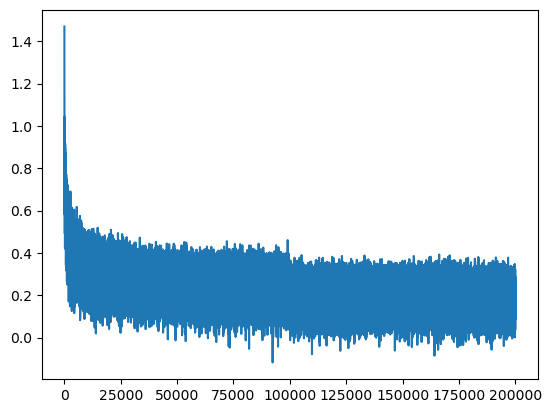

In [23]:
plt.plot(lossi)

In [25]:
# Function to get loss of entire split data
@torch.no_grad() # decorator disables gradient tracking for faster computation
def split_loss(split):
    x, y = {'train': (Xtr, Ytr),
            'val': (Xdev, Ydev),
            'test': (Xte, Yte)}[split] # select split
    
    # FORWARD PASS
    emb = C[x]
    embcat=emb.view(emb.shape[0], -1)
    h=torch.tanh(embcat @ W1 + b1)
    logits = h @ W2 + b2
    loss  = F.cross_entropy(logits, y)

    print(split, loss.item())

# E.g.
split_loss('train')
split_loss('val')

train 1.5790997743606567
val 2.260816812515259


## Problem 1: High initial loss

We can tell from tracking the loss that the initial loss is significantly higher than the value it converges to. This indicates the the initialisation of the MLP is quite off. The moel assigns made up porbabilities to each character, which explains the high loss. Instead, what would we expect as the first loss? This is easy. At initialisation, we expect the MLP to assign a equal probability to each character, this is `1/27`, as the model has no prior information. In this case, for any given char, we expect a loss of:

In [32]:
# Loss=negative log likelihood
-torch.tensor(1/27).log().item()

3.295836925506592

To asign equal probaility to each character at initialisation, we watn ech logit to be the same value, so that the softamx assigns equal probs. For simplicity, we can chose that all logits are 0 at the beginning. How can this be done? We want to manipulate the last layer:

a. Set the bias to 0

b. Multiply the weights of the output layer with a tiny number so that the result logits will be close to zero

First, update the last layer. Second, compute the first loss:

In [39]:
# Updated params to fix initial loss
# Define vocab size, embedding size, and hidden layer size
vocab_size=27
n_embd=10
n_hidden=200

g = torch.Generator().manual_seed(2147483647)

# Parameters
C = torch.randn((vocab_size, n_embd), generator=g)

W1 = torch.randn((n_embd*block_size, n_hidden), generator=g)
b1 = torch.randn((n_hidden), generator=g)

# FIX LOSS HERE
W2 = torch.randn((n_hidden, vocab_size), generator=g) * .01 # Multiply by tiny number
b2 = torch.randn((vocab_size), generator=g) * 0 # to create 0 biases

# Collect params
parameters = [C, W1, b1, W2, b2]

# Set gradients
for p in parameters:
    p.requires_grad=True

# Number of total params
print(sum(p.nelement() for p in parameters))

11897


In [40]:
max_steps=200000
batch_size=32
lossi=[]

for i in range(max_steps):

    # Get minibatch
    ix=torch.randint(0, Xtr.shape[0], (batch_size, ), generator=g) # Indexes of inputs
    Xb, Yb = Xtr[ix], Ytr[ix] # batches

    # FORWARD PASS
    # Embd and concatenation
    emb = C[Xb]
    embcat=emb.view(emb.shape[0], -1)

    # pre activation
    hpreact = embcat @ W1 + b1
    # post activation
    h=torch.tanh(hpreact)

    # logits
    logits = h @ W2 + b2
    # Loss
    loss  = F.cross_entropy(logits, Yb)

    # BACKWARD PASS
    # Set grads to 0
    for p in parameters:
        p.grad=None

    # Backprop
    loss.backward()

    # Update params
    lr = .1 if i < 100000 else .01
    for p in parameters:
        p.data+=-lr*p.grad

    # TRack loss
    if i % 10000 == 0:
        print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
    lossi.append(loss.log10().item())

      0/ 200000: 3.3349
  10000/ 200000: 2.2333
  20000/ 200000: 1.8079
  30000/ 200000: 1.9123
  40000/ 200000: 1.7873
  50000/ 200000: 1.6637
  60000/ 200000: 1.3825
  70000/ 200000: 1.3306
  80000/ 200000: 2.1060
  90000/ 200000: 1.9982
 100000/ 200000: 1.6686
 110000/ 200000: 1.6429
 120000/ 200000: 1.2372
 130000/ 200000: 1.3529
 140000/ 200000: 1.6495
 150000/ 200000: 1.4729
 160000/ 200000: 1.5990
 170000/ 200000: 1.1630
 180000/ 200000: 1.6899
 190000/ 200000: 1.8908


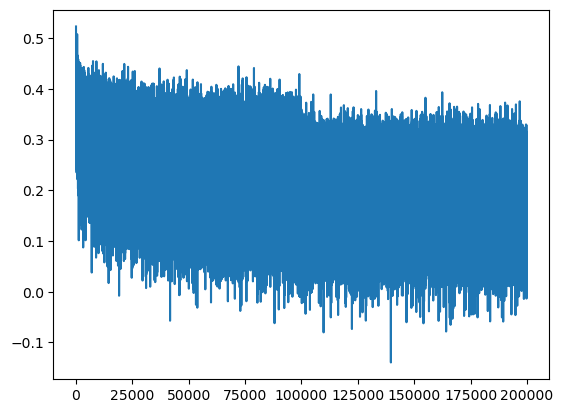

In [41]:
plt.plot(lossi)

In [42]:
# Show train and val loss, which are lower than before
split_loss('train')
split_loss('val')

train 1.552138328552246
val 2.2428407669067383


As expected, when manipulating the inintial weights and biases of the last layer to be 0, we get logits lose to zero, and therefore assign eqaul probs to each character. This results in a sign. lower loss at the beginning. Additionally, we expect also a improvement of the overall loss of the model, as it now has more time to actually adjust the wieghts rrather than squashing the parameters in the first few thousand iterations to the ideal values. Also, when we look at the plot of the losses, we do not see the hockey stick shape anymore, which resulted from the inital high loss.

## Problem 2: Saturated tanh

The activation function, `tanh`, can easily saturate, which means that a neuron outputs a value close to the asymptotic ends of the activation function , that is -1 or 1. The gradient at these tails is close to 0 which inhibits learning. This is a more general problem called "gradient saturation" which applies to most activation functions (tanh, sigmoid, ReLu). Other activation functions, such s Leaky Reulu or ELU, do not suffer that severly from this problem, as they have no falt spots.

If we visualise the activation neurons of the hidden layer we get:

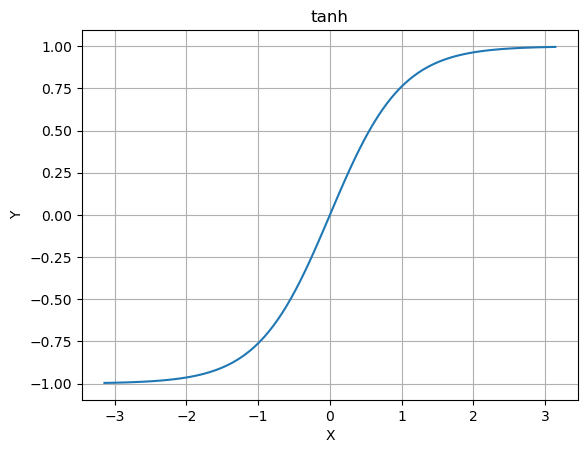

In [62]:
# Plot tanh
plt.plot(np.linspace(-np.pi, np.pi, 100) , np.tanh(np.linspace(-np.pi, np.pi, 100) )) 
plt.title("tanh") 
plt.xlabel("X") 
plt.ylabel("Y")
plt.grid()
plt.show() 

We just run the model for once and break after the initialisation:

In [71]:
# Updated params to fix initial loss
# Define vocab size, embedding size, and hidden layer size
vocab_size=27
n_embd=10
n_hidden=200

g = torch.Generator().manual_seed(2147483647)

# Parameters
C = torch.randn((vocab_size, n_embd), generator=g)

W1 = torch.randn((n_embd*block_size, n_hidden), generator=g)
b1 = torch.randn((n_hidden), generator=g)

# FIX LOSS HERE
W2 = torch.randn((n_hidden, vocab_size), generator=g) * .01 # Multiply by tiny number
b2 = torch.randn((vocab_size), generator=g) * 0 # to create 0 biases

# Collect params
parameters = [C, W1, b1, W2, b2]

# Set gradients
for p in parameters:
    p.requires_grad=True

# Number of total params
print(sum(p.nelement() for p in parameters))

# Training
max_steps=200000
batch_size=32
lossi=[]

for i in range(max_steps):

    # Get minibatch
    ix=torch.randint(0, Xtr.shape[0], (batch_size, ), generator=g) # Indexes of inputs
    Xb, Yb = Xtr[ix], Ytr[ix] # batches

    # FORWARD PASS
    # Embd and concatenation
    emb = C[Xb]
    embcat=emb.view(emb.shape[0], -1)

    # pre activation
    hpreact = embcat @ W1 + b1
    # post activation
    h=torch.tanh(hpreact)

    # logits
    logits = h @ W2 + b2
    # Loss
    loss  = F.cross_entropy(logits, Yb)

    # BACKWARD PASS
    # Set grads to 0
    for p in parameters:
        p.grad=None

    # Backprop
    loss.backward()

    # Update params
    lr = .1 if i < 100000 else .01
    for p in parameters:
        p.data+=-lr*p.grad

    # TRack loss
    if i % 10000 == 0:
        print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
    lossi.append(loss.log10().item())

    break

11897
      0/ 200000: 3.3349


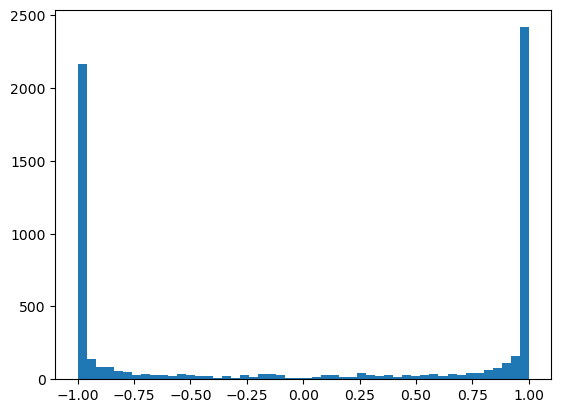

In [72]:
# Visualise pre-activations of the hidden layer
plt.hist(h.view(-1).tolist(), 50);

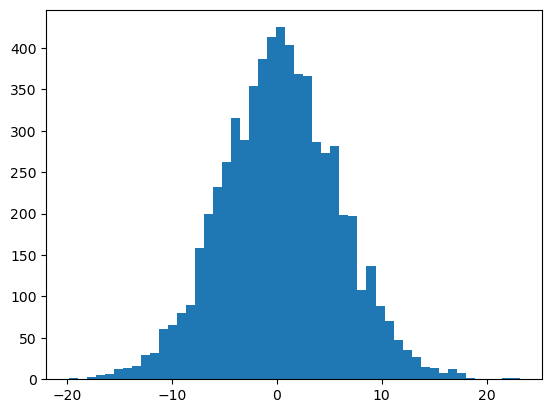

In [73]:
# Visualise activations of the hidden layer
plt.hist(hpreact.view(-1).tolist(), 50);

__Problem__

We see a highly unequal distribution, where we have the majority of activation neurons close to -1 or 1, that is most neurons are very active. Why is this the case? This is because the 
pre-activation values of the hidden layers take on a lot of "extreme" values which leads `tanh` to assign values at its tails as the function squashes values between -1 and 1. In other words,
the variance of the pre-activation neurons is too high, which leads to a lot of activation values being saturated.

  This is a __major problem__ of this layer. If we look at the computation of `tanh` we see why:

```
def tanh(self):
    ''''Returns the tanh value for the stored data'''
    n = self.data
    t = (math.exp(2*n) - 1)/(math.exp(2*n) + 1)
    out = Value(t, (self,), 'tanh') # Just one child, as tanh takes the scalar of the neuron

    def _backward():
        '''Implements the backprop function for a tanh object.'''
        self.grad += (1-t**2) * (out.grad) # local derivative of tanh*derivative of the output

    # Assigns the tanh function to the _backward attribute of the object
    out._backward = _backward
    return out
```

When we backpropagate through `tanh` and its value is close to -1 or 1, then the gradient of the children will be very low if not 0. This makes mathematically sense, as the first derivative at the
 tails of `tanh` is close to 0 because its value remains constant. Intuitively, this makes even more sense. The input of the activation will not affect the loss too much when it is already
 in a flat region of the activation function. Changing the input sighlty won't sign. change the value of `tanh`, and hence cannot have an effect on the loss.

What this causes is that it kills the backpropagation for the remaining neurons. That means that the adjustments of the weights influencing this neuron will not change the loss. 
Their gradients are close to 0. Imagine that all the activation neurons at this layer are at the flat tails of `tanh`, then the backpropagation would be completely destroyed at this layer.


__tanh at 0.5__

If `tanh` is .5 then the neuron is inactive as it simply passes through the gradient to its children. Hence, the gradient passed through tanh can only evere _decrease_. 
If `tanh` mvoes away from .5, then the gradient is passed through proportional to the (squared) value of `tanh`.

We can also visualise the neurons of the hidden layer, and check how oten the neurons are at the flat tails. Below each row is an input and each column is a neuron of this layer. A white box
indicates neurons that are larger than -1 or 1.

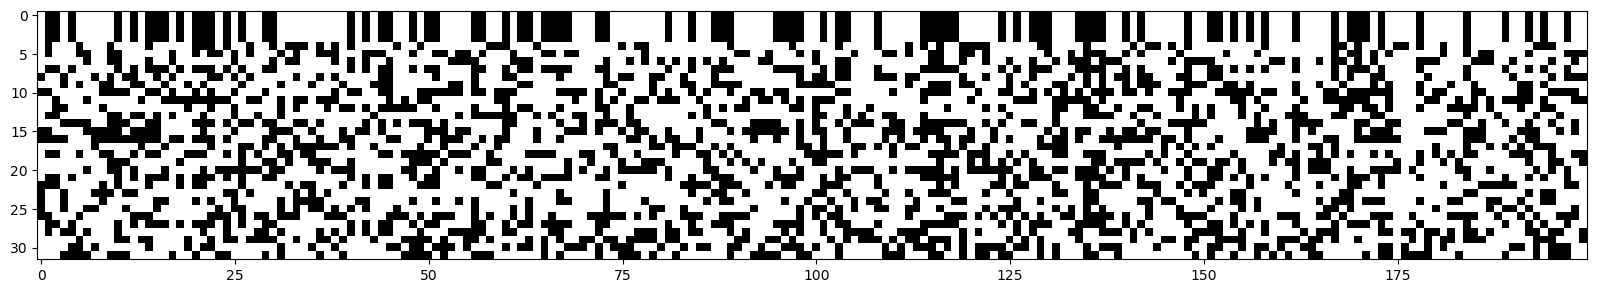

In [74]:
# Show neurons of hidden layer for each input
plt.figure(figsize=(20,10))
plt.imshow(h.abs() > .99, cmap='gray', interpolation='nearest');

We talk about a "dead" neuron if for all inputs, the activation is -1 or 1 (a column is fully white). Then this neuron will never learn and passes through gradients that are close to 0, and thus does not contribute to the learning of the weights and biases inlfuencing this neuron. In other words, no matter how params for this neuron are changed, for any inputs, the neuron will always contribute the same way to the loss.

__When does this happen__

This can happen at chance at initialisation, when the weights and biases are set so that the activation is by chance at the tail ends. Or it can happen during learning. For example, when the learning rate is too high, then the activation can be knocked out to the tails. Both can lead to dead neurons.

__Solution__

As we have seen, the pre-activation values are too extreme which leads to the saturation of the `tanh`. In other word, the pre-activation values from the hidden layer are too far off from 0. We can thus follow the same idea as above and multiply `b1` and `w1` by a small number so that we keep the resulting distrbiution of pre-activation values tighter.

In [79]:
# Updated params to fix initial loss
# Define vocab size, embedding size, and hidden layer size
vocab_size=27
n_embd=10
n_hidden=200

g = torch.Generator().manual_seed(2147483647)

# Parameters
C = torch.randn((vocab_size, n_embd), generator=g)

W1 = torch.randn((n_embd*block_size, n_hidden), generator=g) * 0.2
b1 = torch.randn((n_hidden), generator=g) * 0.01

# FIX LOSS HERE
W2 = torch.randn((n_hidden, vocab_size), generator=g) * .01 # Multiply by tiny number
b2 = torch.randn((vocab_size), generator=g) * 0 # to create 0 biases

# Collect params
parameters = [C, W1, b1, W2, b2]

# Set gradients
for p in parameters:
    p.requires_grad=True

# Number of total params
print(sum(p.nelement() for p in parameters))

# Training
max_steps=200000
batch_size=32
lossi=[]

for i in range(max_steps):

    # Get minibatch
    ix=torch.randint(0, Xtr.shape[0], (batch_size, ), generator=g) # Indexes of inputs
    Xb, Yb = Xtr[ix], Ytr[ix] # batches

    # FORWARD PASS
    # Embd and concatenation
    emb = C[Xb]
    embcat=emb.view(emb.shape[0], -1)

    # pre activation
    hpreact = embcat @ W1 + b1
    # post activation
    h=torch.tanh(hpreact)

    # logits
    logits = h @ W2 + b2
    # Loss
    loss  = F.cross_entropy(logits, Yb)

    # BACKWARD PASS
    # Set grads to 0
    for p in parameters:
        p.grad=None

    # Backprop
    loss.backward()

    # Update params
    lr = .1 if i < 100000 else .01
    for p in parameters:
        p.data+=-lr*p.grad

    # TRack loss
    if i % 10000 == 0:
        print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
    lossi.append(loss.log10().item())

    break

11897
      0/ 200000: 3.3257


We can now again visualise the pre- and post activation values:

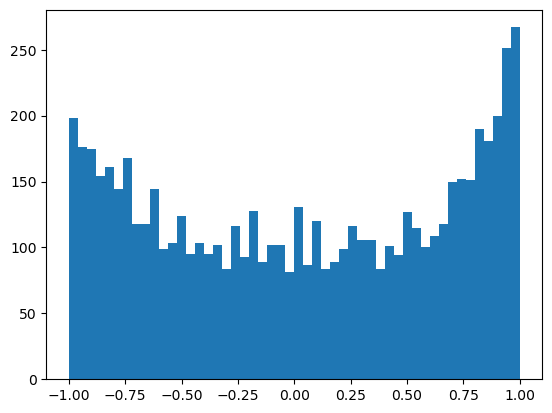

In [80]:
# Visualise pre-activations of the hidden layer
plt.hist(h.view(-1).tolist(), 50);

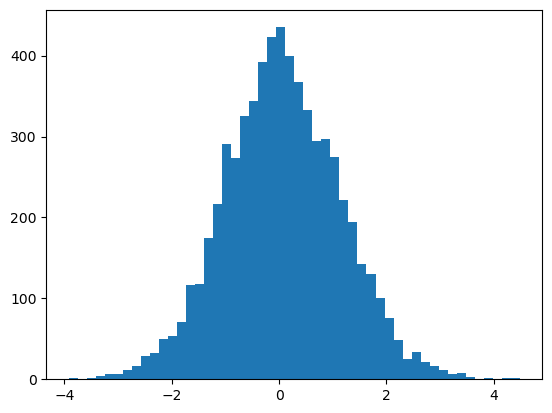

In [81]:
# Visualise activations of the hidden layer
plt.hist(hpreact.view(-1).tolist(), 50);

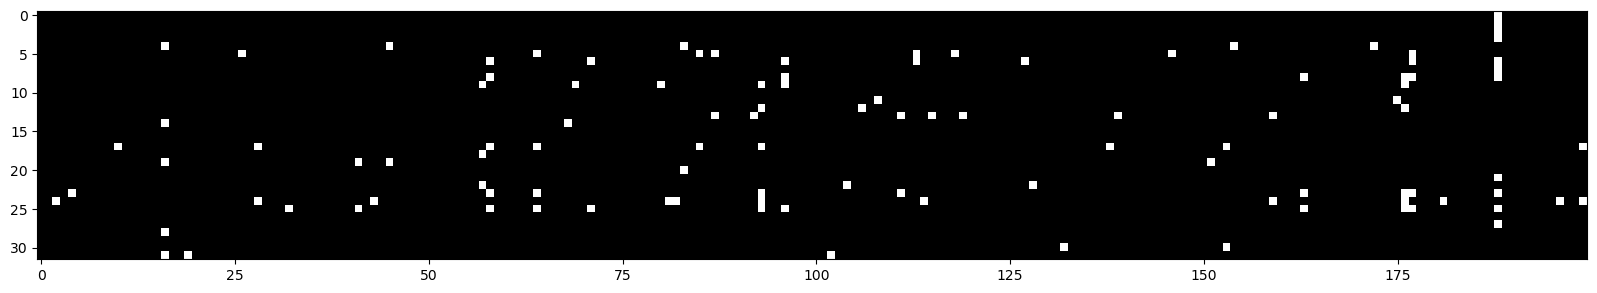

In [82]:
# Show neurons of hidden layer for each input
plt.figure(figsize=(20,10))
plt.imshow(h.abs() > .99, cmap='gray', interpolation='nearest');

Now, in this distribution, we can see that we have jsut a few neurons saturated at initialisation. The squeezing of the pre-activation values thus helped to descrease the number if neurons that are already -1 or 1 at the beginning o the training.

We can now run the full netwoek with this trick and will see that we will likely have an improved loss. Why? Because we have optimised the backrpopagation when we have less saturated neurons.

In [83]:
# Updated params to fix initial loss
# Define vocab size, embedding size, and hidden layer size
vocab_size=27
n_embd=10
n_hidden=200

g = torch.Generator().manual_seed(2147483647)

# Parameters
C = torch.randn((vocab_size, n_embd), generator=g)

W1 = torch.randn((n_embd*block_size, n_hidden), generator=g) * 0.2
b1 = torch.randn((n_hidden), generator=g) * 0.01

# FIX LOSS HERE
W2 = torch.randn((n_hidden, vocab_size), generator=g) * .01 # Multiply by tiny number
b2 = torch.randn((vocab_size), generator=g) * 0 # to create 0 biases

# Collect params
parameters = [C, W1, b1, W2, b2]

# Set gradients
for p in parameters:
    p.requires_grad=True

# Number of total params
print(sum(p.nelement() for p in parameters))

# Training
max_steps=200000
batch_size=32
lossi=[]

for i in range(max_steps):

    # Get minibatch
    ix=torch.randint(0, Xtr.shape[0], (batch_size, ), generator=g) # Indexes of inputs
    Xb, Yb = Xtr[ix], Ytr[ix] # batches

    # FORWARD PASS
    # Embd and concatenation
    emb = C[Xb]
    embcat=emb.view(emb.shape[0], -1)

    # pre activation
    hpreact = embcat @ W1 + b1
    # post activation
    h=torch.tanh(hpreact)

    # logits
    logits = h @ W2 + b2
    # Loss
    loss  = F.cross_entropy(logits, Yb)

    # BACKWARD PASS
    # Set grads to 0
    for p in parameters:
        p.grad=None

    # Backprop
    loss.backward()

    # Update params
    lr = .1 if i < 100000 else .01
    for p in parameters:
        p.data+=-lr*p.grad

    # TRack loss
    if i % 10000 == 0:
        print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
    lossi.append(loss.log10().item())

11897
      0/ 200000: 3.3257
  10000/ 200000: 2.1697
  20000/ 200000: 1.7436
  30000/ 200000: 1.8685
  40000/ 200000: 1.4940
  50000/ 200000: 1.5684
  60000/ 200000: 1.3965
  70000/ 200000: 1.2732
  80000/ 200000: 2.0510
  90000/ 200000: 1.9089
 100000/ 200000: 1.5444
 110000/ 200000: 1.6170
 120000/ 200000: 1.2197
 130000/ 200000: 1.3792
 140000/ 200000: 1.6437
 150000/ 200000: 1.4535
 160000/ 200000: 1.5897
 170000/ 200000: 1.1873
 180000/ 200000: 1.7406
 190000/ 200000: 1.8796


In [85]:
# Show loss which is better than before
split_loss('train')
split_loss('val')

train 1.5348619222640991
val 2.179687738418579
